In [1]:
import sys , os
sys.path.append('../')

from dnn.bitwise_autoencoder import *
from dnn.bitwise_ss import *
from datasets.two_source_mixture import *
from datasets.sinusoidal_data import *
from datasets.quantized_data import *
from datasets.binary_data import *
from loss_and_metrics.bss_eval import *
import torch
import numpy as np
import IPython.display as ipd
import soundfile as sf
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Inverse Blues colormap
cdict = {
    'red':   ((0.0,  1.0, 1.0), (1.0,  0.0, 0.0)),
    'green': ((0.0,  1.0, 1.0), (1.0,  .15, .15)),
    'blue':  ((0.0,  1.0, 1.0), (1.0,  0.4, 0.4)),
    'alpha': ((0.0,  0.0, 0.0), (1.0,  1.0, 1.0))}
plt.register_cmap(name='InvBlueA', data=cdict)

# Customize my figure style
plt.rc( 'figure', figsize=(8,4), dpi=96, facecolor='#FFFFFF00', autolayout=False)
plt.rc( 'lines', linewidth=1)
plt.rc( 'axes', axisbelow=True, titlesize=10, titleweight=500, 
   labelsize=9, labelweight=400, linewidth=0.5, facecolor='#FFFFFF00')
plt.rc( 'xtick', labelsize=8)
plt.rc( 'ytick', labelsize=8)
plt.rc( 'axes.spines', right=False, top=False)
plt.rc( 'grid', linestyle='-', linewidth=0.5)

# Get a decent figure font
matplotlib.font_manager._rebuild()
plt.rc('font', family='Avenir Next LT Pro', weight=400, size=9)

# Light colors
plt.rc( 'axes', edgecolor='#404040')
plt.rc( 'grid', color='#DDDDDD')
plt.rc( 'xtick', color='#222222')
plt.rc( 'ytick', color='#222222')
plt.rc( 'text', color='#222222')
plt.rc( 'image', cmap='InvBlueA')
plt.rc( 'legend', facecolor='#FFFFFF55', framealpha=0.5)

%load_ext autoreload
%autoreload 2

# Binary Neural Network

In [2]:
def evaluate_binary(model, binary_val, valset, max_samples=400):
    bss_metrics = BSSMetricsList()
    for i in range(len(binary_val)):
        if i >= max_samples:
            return bss_metrics
        sample = valset[i]
        mix = sample['mixture']
        target = sample['target']
        val_mag, val_phase = stft(mix)
        interference = sample['interference']
        bmag = torch.FloatTensor(binary_val[i]['bmag']).unsqueeze(0)
        model_in = flatten(bmag)
        premask = model(model_in)
        premask = unflatten(premask, bmag.size(0), bmag.size(2))
        mask = make_binary_mask(premask).squeeze(0)
        estimate = istft(val_mag * mask.numpy(), val_phase)
        sources = np.stack([target, interference], axis=0)
        metric = bss_eval_np(estimate, sources)
        bss_metrics.append(metric)
    return bss_metrics

def run_evaluation(model, dl):
    bss_metrics = BSSMetricsList()
    for batch in dl:
        metrics = evaluate(model, batch)
        bss_metrics.extend(metrics)
            
    sdr, sir, sar = bss_metrics.mean()
    print('Mean SDR %f' % sdr)
    print('Mean SIR %f' % sir)
    print('Mean SAR %f'% sar)
    return bss_metrics
    
def get_audio_output(model, binary_sample, raw_sample):
    mix = raw_sample['mixture']
    target = raw_sample['target']
    val_mag, val_phase = stft(mix)
    bmag = torch.FloatTensor(binary_sample['bmag']).unsqueeze(0)
    model_in = flatten(bmag)
    premask = model(model_in)
    premask = unflatten(premask, bmag.size(0), bmag.size(2))
    mask = make_binary_mask(premask).squeeze(0)
    estimate = istft(val_mag * mask.numpy(), val_phase)
    ipd.display(ipd.Audio(mix, rate=16000))
    ipd.display(ipd.Audio(estimate, rate=16000))
    ipd.display(ipd.Audio(target, rate=16000))
    
def visualize_mask(binary_sample, raw_sample, model=None):
    _, _, mask, ibm = evaluate(binary_sample, raw_sample, model)
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.pcolormesh(ibm, cmap='binary')
    plt.subplot(122)
    plt.pcolormesh(mask, cmap='binary')
    
def visualize_input(binary_sample, num_bits=4):
    bmag, ibm = binary_sample['bmag'], binary_sample['ibm']
    qmag = np.zeros((bmag.shape[0] // num_bits, bmag.shape[1]))
    for i in range(bmag.shape[0] // num_bits):
        for j in range(num_bits):
            qmag[i] += 2**(num_bits - j - 1) * bmag[num_bits*i + j]
    
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.pcolormesh(qmag, cmap='binary')
    plt.subplot(122)
    plt.pcolormesh(ibm, cmap='binary')

Number of Training Examples:  3600
Number of Validation Examples:  400


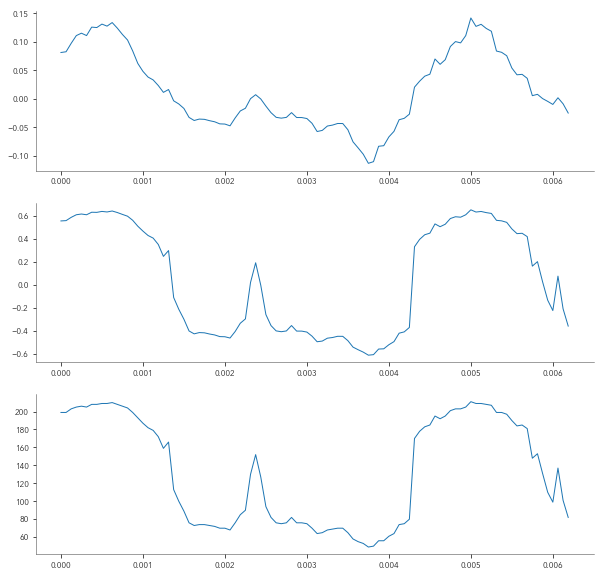

In [3]:
# Configuration
toy = False
sample_rate = 16000
num_bits = 8
quantizer = Quantizer(min=-1, delta=2/(2**num_bits), num_bits=num_bits)
trainset, valset, testset = make_mixture_set(toy=toy)
print('Number of Training Examples: ', len(trainset))
print('Number of Validation Examples: ', len(valset))
sample = trainset[0]['mixture'][8000:8100]
time = np.arange(len(sample))/16000
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.plot(time, sample)
plt.subplot(3, 1, 2)
mu_sample = mu_law(torch.FloatTensor(sample), 256)
plt.plot(time, mu_sample.numpy())
plt.subplot(3, 1, 3)
qsample = quantizer(torch.FloatTensor(sample))
plt.plot(time, qsample.numpy())

In [4]:
binary_train = BinaryDataset('/media/data/binary_audio/train')
binary_val = BinaryDataset('/media/data/binary_audio/val')
binary_test = BinaryDataset('/media/data/binary_audio/test')
print('Number of Binary Training Examples: ', len(binary_train))
print('Number of Binary Validation Examples: ', len(binary_val))
print('Number of Binary Test Examples: ', len(binary_test))

Number of Binary Training Examples:  3600
Number of Binary Validation Examples:  400
Number of Binary Test Examples:  400


(513, 91)


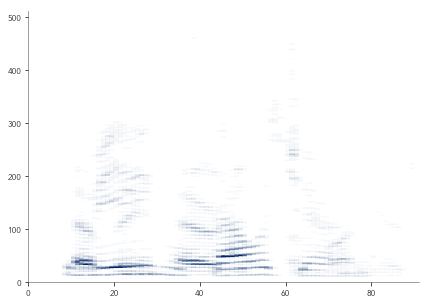

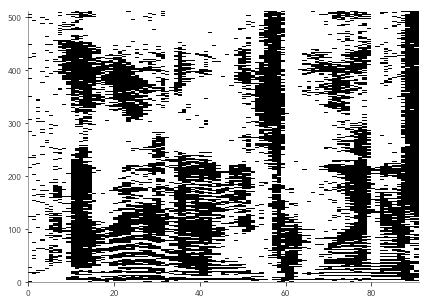

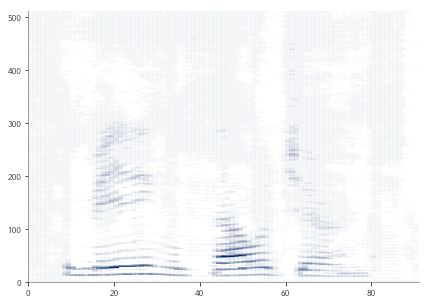

In [5]:
sample = binary_train[0]
quantizer = Quantizer(min=-1, delta=2/2**(4), num_bits=4, use_mu=True)
disperser = Disperser(4)
bmag = sample['bmag']
ibm = sample['ibm']

mix = accumulate(bmag, quantizer, disperser)
print(mix.shape)
plt.figure(figsize=(7, 5))
plt.pcolormesh(np.sqrt(mix))
plt.figure(figsize=(7, 5))
plt.pcolormesh(ibm, cmap='gray')
targ = ibm * mix
plt.figure(figsize=(7, 5))
plt.pcolormesh(np.sqrt(targ))

In [6]:
# Load Dataset
sample = trainset[0]
targ = torch.FloatTensor(sample['target'])
quantized_targ = quantizer(targ)
reconstructed_targ = quantizer.inverse(quantized_targ)
ipd.display(ipd.Audio(targ, rate=16000))
ipd.display(ipd.Audio(reconstructed_targ, rate=16000))

## Bitwise Neural Network Evaluation

In [7]:
# Evaluate real source separation network
mlp = BitwiseMLP(2052, 513, fc_sizes=[2048, 2048])
mlp.load_state_dict(torch.load('../models/net.model'))
mlp.eval()
met = evaluate_binary(mlp, binary_test, testset)
sdr, sir, sar = met.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_val[0], valset[0])

Mean SDR:  7.861241161235858
Mean SIR:  18.926905274322365
Mean SAR:  8.579021307836905


In [8]:
# Evaluate real source separation network
mlp = BitwiseMLP(2052, 513, fc_sizes=[2048, 2048])
mlp.load_state_dict(torch.load('../models/bnet_sp0.model'))
mlp.eval()
mlp.noisy()
bmet_sp0 = evaluate_binary(mlp, binary_test, testset)
sdr, sir, sar = bmet_sp0.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_val[0], valset[0])

Mean SDR:  6.995971565267312
Mean SIR:  17.05346671914826
Mean SAR:  7.9231278905091935


In [9]:
# Evaluate real source separation network
mlp = BitwiseMLP(2052, 513, fc_sizes=[2048, 2048])
mlp.load_state_dict(torch.load('../models/bnet_sp33.model'))
mlp.eval()
mlp.noisy()
bmet_sp33 = evaluate_binary(mlp, binary_test, testset)
sdr, sir, sar = bmet_sp33.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_val[0], valset[0])

Mean SDR:  7.132573578979475
Mean SIR:  18.06435849750894
Mean SAR:  7.884685952321567


In [10]:
# Evaluate real source separation network
mlp = BitwiseMLP(2052, 513, fc_sizes=[2048, 2048])
mlp.load_state_dict(torch.load('../models/bnet_sp40.model'))
mlp.eval()
mlp.noisy()
bmet_sp40 = evaluate_binary(mlp, binary_test, testset)
sdr, sir, sar = bmet_sp40.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_val[0], valset[0])

Mean SDR:  7.2003562575823095
Mean SIR:  17.034809098568616
Mean SAR:  8.165974973305245


In [11]:
# Evaluate real source separation network
mlp = BitwiseMLP(2052, 513, fc_sizes=[2048, 2048])
mlp.load_state_dict(torch.load('../models/bnet_sp50.model'))
mlp.eval()
mlp.noisy()
bmet_sp50 = evaluate_binary(mlp, binary_test, testset)
sdr, sir, sar = bmet_sp50.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_val[0], valset[0])

Mean SDR:  7.273326017385968
Mean SIR:  16.69879864122628
Mean SAR:  8.31037192531624


In [30]:
# Evaluate real filter gate
mlp = BitwiseMLP(2052, 513, fc_sizes=[2048, 2048], use_gate=True)
mlp.load_state_dict(torch.load('../models/net_ug.model'))
mlp.eval()
met_ug = evaluate_binary(mlp, binary_test, testset)
sdr, sir, sar = met_ug.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_test[0], testset[0])

Mean SDR:  7.872177292864015
Mean SIR:  19.50822586642762
Mean SAR:  8.512346889893088


In [15]:
# Evaluate binary filter gate
mlp = BitwiseMLP(2052, 513, fc_sizes=[2048, 2048], use_gate=True)
mlp.load_state_dict(torch.load('../models/bnet_ug.model'))
mlp.noisy()
mlp.eval()
bmet_ug = evaluate_binary(mlp, binary_test, testset)
sdr, sir, sar = bmet_ug.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_test[0], testset[0])

total_pass = torch.sum((mlp.filter_list[0].gate > 0).float()) + \
      torch.sum((mlp.filter_list[1].gate > 0).float()) + \
      torch.sum((mlp.filter_list[2].gate > 0).float())
total_units = mlp.filter_list[0].gate.view(-1).size(0) + \
     mlp.filter_list[1].gate.view(-1).size(0) + \
     mlp.filter_list[2].gate.view(-1).size(0)
total_pass / total_units

Mean SDR:  7.121282927926238
Mean SIR:  18.09402871541778
Mean SAR:  7.91333043504094


tensor(0.3132)

In [24]:
# Evaluate real filter gate
mlp = BitwiseMLP(2052, 513, fc_sizes=[2048, 2048])
mlp.load_state_dict(torch.load('../models/bnet_nt1.model'))
mlp.eval()
met_nt1 = evaluate_binary(mlp, binary_test, testset)
sdr, sir, sar = met_nt1.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_test[0], testset[0])

Mean SDR:  0.5032141293670163
Mean SIR:  3.15580203377805
Mean SAR:  6.194645196722038


In [16]:
sdrs = np.stack([met.sdrs, bmet_sp0.sdrs, bmet_sp33.sdrs, bmet_sp50.sdrs, bmet_ug.sdrs], axis=1)
sirs = np.stack([met.sirs, bmet_sp0.sirs, bmet_sp33.sirs, bmet_sp50.sirs, bmet_ug.sirs], axis=1)
sars = np.stack([met.sars, bmet_sp0.sars, bmet_sp33.sars, bmet_sp50.sars, bmet_ug.sars], axis=1)
labels = ['real baseline', 'sp0', 'sp33', 'sp50', 'filter-gate']

Text(0, 0.5, 'SDR (dB)')

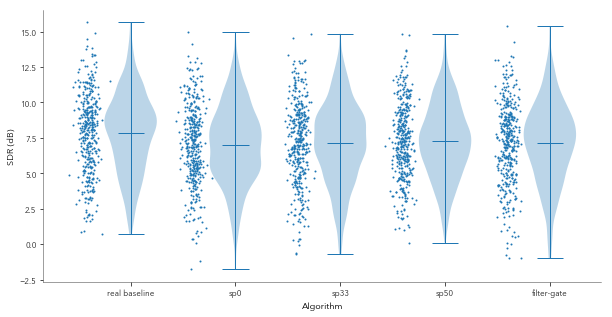

In [19]:
plt.figure(figsize=(10, 5))
plt.violinplot(sdrs, bw_method=.25, showmeans=True)
plt.xticks(np.arange(1, len(labels)+1), labels)
for i in range(5):
    plt.plot(i+np.random.randn(400)/20+.6, sdrs[:,i], 'C0.', ms=2)
plt.xlabel('Algorithm')
plt.ylabel('SDR (dB)')

Text(0, 0.5, 'SIR (dB)')

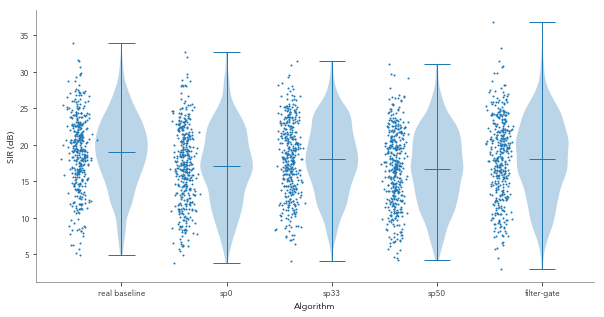

In [20]:
plt.figure(figsize=(10, 5))
plt.violinplot(sirs, bw_method=.25, showmeans=True)
plt.xticks(np.arange(1, len(labels)+1), labels)
for i in range(5):
    plt.plot( i+np.random.randn(400)/20+.6, sirs[:,i], 'C0.', ms=2)
plt.xlabel('Algorithm')
plt.ylabel('SIR (dB)')

Text(0, 0.5, 'SAR (dB)')

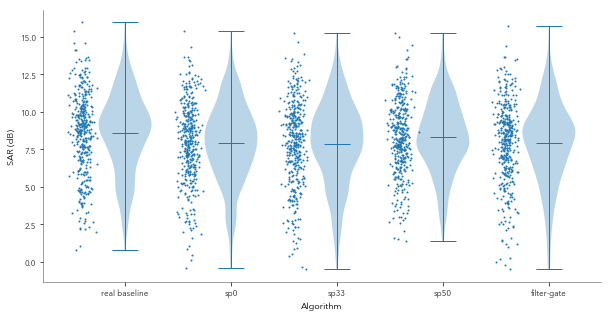

In [21]:
plt.figure(figsize=(10, 5))
plt.violinplot(sars, bw_method=.25, showmeans=True)
plt.xticks(np.arange(1, len(labels)+1), labels)
for i in range(5):
    plt.plot( i+np.random.randn(400)/20+.6, sars[:,i], 'C0.', ms=2)
plt.xlabel('Algorithm')
plt.ylabel('SAR (dB)')